# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Implement an Agent

The agent is implemented in ddpg_agent.py. It uses the neural network architectures in model.py.

### 4. Train the Agent

In [5]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

%matplotlib notebook

def init_plot():
    fig,ax = plt.subplots(1,1)
    ax.grid(True)
    ax.set_xlabel('Episode #')
    return fig, ax

def live_plot(fig, ax, data_dict, figsize=(7,5), title=''):
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(list(range(len(data_dict[line.get_label()]))))
            line.set_ydata(data_dict[line.get_label()])
        ax.set_xlim(0, len(data_dict[line.get_label()]))
        
    else:
        for label,data in data_dict.items():
            line, = ax.plot(data)
            line.set_label(label)
            ax.legend()
        ax.set_ylim(0, 45)
    
    fig.canvas.draw()

<IPython.core.display.Javascript object>


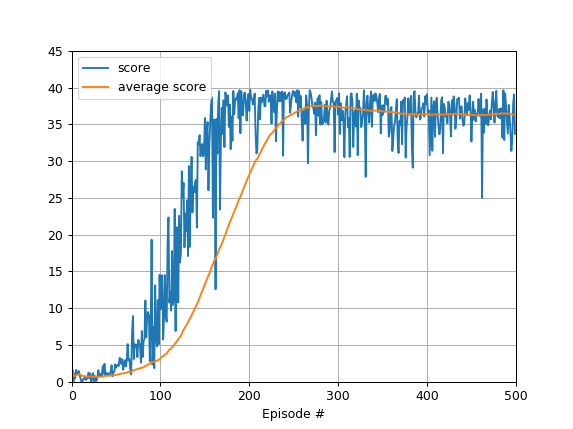

Episode 100	Average Score: 3.08 	Duration: 19.128744 Min
Episode 200	Average Score: 27.87 	Duration: 20.681876 Min
Episode 300	Average Score: 37.39 	Duration: 22.394558 Min
Episode 400	Average Score: 36.34 	Duration: 24.162473 Min
Episode 500	Average Score: 36.28 	Duration: 26.480263 Min


In [6]:
import time
import torch
from collections import defaultdict, deque

from ddpg_agent import Agent

def train(n_episodes=500, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores_for_visualization = defaultdict(list)
    
    fig, ax = init_plot()
    
    for i_episode in range(1, n_episodes + 1):
        episode_start = time.time()
        
        env_info  = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            
            # update scores and states
            scores += env_info.rewards
            states = next_states
            if np.any(dones):
                break
                
        # save score
        score = np.mean(scores).astype(float)
        scores_deque.append(score)
        scores_for_visualization["score"].append(score)
        scores_for_visualization["average score"].append(np.mean(scores_deque))

        # print current performance
        live_plot(fig, ax, scores_for_visualization)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")

        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} \tDuration: {:.6f} Min'.format(i_episode, 
                                                                                      np.mean(scores_deque), 
                                                                                     (time.time() - episode_start) / 60. * print_every
                                                                                     ))
            
    return

agent = Agent(state_size, action_size, seed=0, batch_size=512)
scores = train()

### 4. Watch a Smart Agent!

In [7]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info  = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations
for t in range(200):
    action = agent.act(state, add_noise=False)
    env_info = env.step(action)[brain_name]
    if env_info.local_done:
        break 

In [8]:
# env.close()